In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MaxPoolingLayer(nn.Module):
    def __init__(self, pool_size=2):
        """
        Max Pooling Layer (Custom Implementation).
        :param pool_size: Size of the pooling window.
        """
        super(MaxPoolingLayer, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        """
        Forward pass of the max-pooling layer.
        """
        batch_size, channels, height, width = x.size()
        output_height, output_width = height // self.pool_size, width // self.pool_size

        # Initialize output tensor
        pooled_output = torch.zeros((batch_size, channels, output_height, output_width)).to(x.device)

        # Loop over pooling windows
        for i in range(0, height, self.pool_size):
            for j in range(0, width, self.pool_size):
                # Extract the current pooling window
                window = x[:, :, i:i + self.pool_size, j:j + self.pool_size]

                # Compute the maximum value in the window
                max_value = torch.max(window.reshape(batch_size, channels, -1), dim=2)[0]

                # Assign the max value to the corresponding location in the output tensor
                pooled_output[:, :, i // self.pool_size, j // self.pool_size] = max_value

        return pooled_output


In [3]:
class MaxPoolingCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Simple CNN with Max Pooling Layer.
        """
        super(MaxPoolingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # conv1 has 32 filters, so it produces 32 output channels
        self.max_pool = MaxPoolingLayer(pool_size=2)
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolutional layer
        x = self.max_pool(x)       # First max pooling
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc1(x)            # Fully connected layer to output classes
        return x

In [4]:
class FuzzyPoolingLayer(nn.Module):
    def __init__(self, pool_size=2):
        """
        Fuzzy Pooling Layer
        :param pool_size: Size of pooling window
        """
        super(FuzzyPoolingLayer, self).__init__()
        self.pool_size = pool_size

    def gaussian_membership(self, x, mean, std):
        """
        Compute Gaussian Membership Function (GMF) for input tensor.
        """
        return torch.exp(-((x - mean) ** 2) / (2 * std ** 2))

    def forward(self, x):
        """
        Forward pass of the fuzzy-based pooling layer.
        """
        batch_size, channels, height, width = x.size()
        output_height, output_width = height // self.pool_size, width // self.pool_size

        # Initialize pooled output
        pooled_output = torch.zeros((batch_size, channels, output_height, output_width)).to(x.device)

        # Loop over pooling windows
        for i in range(0, height, self.pool_size):
            for j in range(0, width, self.pool_size):
                # Extract the current pooling window
                window = x[:, :, i:i + self.pool_size, j:j + self.pool_size]

                # Compute mean and standard deviation for the window
                mean = window.mean(dim=(2, 3), keepdim=True)
                std = window.std(dim=(2, 3), keepdim=True) + 1e-8  # Avoid divide-by-zero

                # Compute GMF (Gaussian Membership Function) values for the window
                gmf = self.gaussian_membership(window, mean, std)

                # Threshold: S-norm (max) followed by T-norm (min)
                threshold = torch.min(torch.max(gmf, dim=3)[0], dim=2)[0].unsqueeze(-1).unsqueeze(-1)

                # Identify dominant features (only keep elements above the threshold)
                dominant_features = window * (gmf >= threshold).float()

                # Compute weighted average of the dominant features
                weights = gmf / (gmf.sum(dim=(2, 3), keepdim=True) + 1e-8)
                pooled_value = (dominant_features * weights).sum(dim=(2, 3))

                # Assign the pooled value to the corresponding location in the output tensor
                pooled_output[:, :, i // self.pool_size, j // self.pool_size] = pooled_value

        return pooled_output

In [5]:
class FuzzyCNN(nn.Module):
    def __init__(self, num_classes=10):
        """
        Simple CNN with Fuzzy-Based Pooling Layer.
        """
        super(FuzzyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  ## self.conv1 = nn.Conv2d(in_channels=3 (RGB), out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fuzzy_pool = FuzzyPoolingLayer(pool_size=2)
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.fuzzy_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc1(x)
        return x

In [6]:
# Training function with loss & accuracy tracking
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()

    # Lists to store loss and accuracy per epoch for plotting
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute average loss and accuracy for this epoch
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total

        # Store values for plotting
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Plot the loss and accuracy graphs
    plot_metrics(epoch_losses, epoch_accuracies)

# Helper function to plot loss and accuracy
def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, '-o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, '-o', label='Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    # Show the plots
    plt.show()



In [7]:
# Example Usage
if __name__ == "__main__":
    from torchvision.datasets import MNIST
    from torchvision.transforms import ToTensor
    from torch.utils.data import DataLoader

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    train_dataset = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.58MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.69MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Epoch [1/5], Loss: 0.2259, Accuracy: 93.68%
Epoch [2/5], Loss: 0.0797, Accuracy: 97.67%
Epoch [3/5], Loss: 0.0602, Accuracy: 98.22%
Epoch [4/5], Loss: 0.0506, Accuracy: 98.50%
Epoch [5/5], Loss: 0.0430, Accuracy: 98.71%


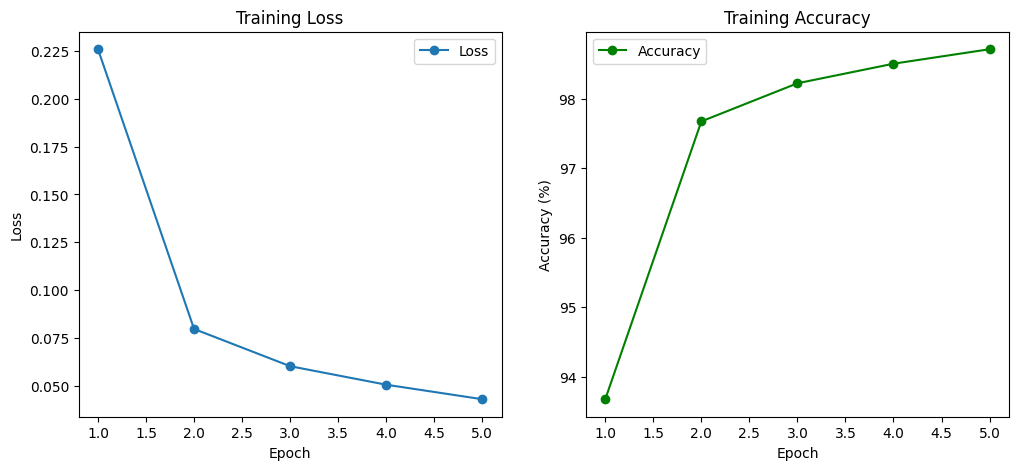

In [8]:
    # Initialize model, loss, and optimizer
    modelMax = MaxPoolingCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelMax.parameters(), lr=0.001)

    # Train the model
    train(modelMax, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.3343, Accuracy: 90.77%
Epoch [2/5], Loss: 0.1494, Accuracy: 95.82%
Epoch [3/5], Loss: 0.1032, Accuracy: 97.13%
Epoch [4/5], Loss: 0.0796, Accuracy: 97.74%
Epoch [5/5], Loss: 0.0681, Accuracy: 98.04%


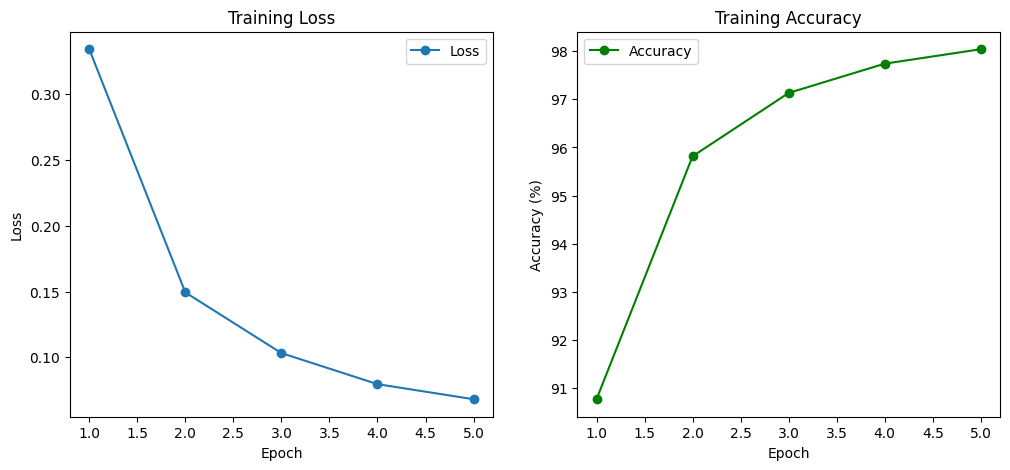

In [9]:
    # Initialize model, loss, and optimizer
    modelFuzzy = FuzzyCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelFuzzy.parameters(), lr=0.001)

    # Train the model
    train(modelFuzzy, train_loader, criterion, optimizer, epochs=5)

In [10]:
class AveragePoolingLayer(nn.Module):
    def __init__(self, pool_size=2):
        """
        Average Pooling Layer
        :param pool_size: Size of pooling window
        """
        super(AveragePoolingLayer, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        return self.pool(x)


class CNNWithAveragePooling(nn.Module):
    def __init__(self, num_classes=10):
        """
        Simple CNN with Average Pooling Layer.
        """
        super(CNNWithAveragePooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.avg_pool = AveragePoolingLayer(pool_size=2)
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc1(x)
        return x

Epoch [1/5], Loss: 0.3051, Accuracy: 91.33%
Epoch [2/5], Loss: 0.1167, Accuracy: 96.86%
Epoch [3/5], Loss: 0.0775, Accuracy: 97.78%
Epoch [4/5], Loss: 0.0622, Accuracy: 98.19%
Epoch [5/5], Loss: 0.0521, Accuracy: 98.48%


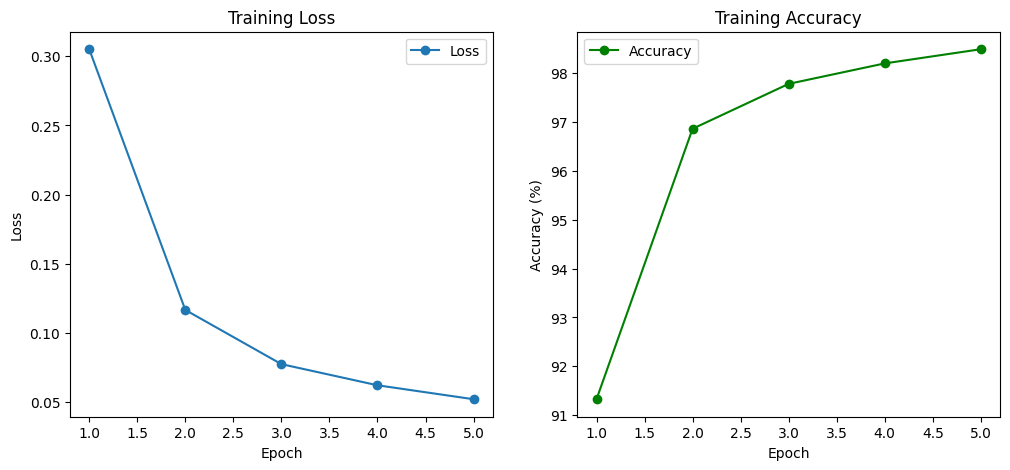

In [11]:
    # Initialize model, loss, and optimizer
    modelAvg = CNNWithAveragePooling(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelAvg.parameters(), lr=0.001)

    # Train the model
    train(modelAvg, train_loader, criterion, optimizer, epochs=5)

In [12]:
class FuzzyPoolingLayer(nn.Module):
    def __init__(self, pool_size=2, reg_lambda=0.01):
        """
        Fuzzy Pooling Layer with RegP (Regularization by Pooling).
        :param pool_size: Size of pooling window
        :param reg_lambda: Regularization factor to control sparsity.
        """
        super(FuzzyPoolingLayer, self).__init__()
        self.pool_size = pool_size
        self.reg_lambda = reg_lambda  # Controls regularization strength

    def gaussian_membership(self, x, mean, std):
        """
        Compute Gaussian Membership Function (GMF) for input tensor.
        """
        return torch.exp(-((x - mean) ** 2) / (2 * std ** 2))

    def regularization_penalty(self, gmf):
        """
        RegP: Compute the regularization penalty for GMF activations.
        This penalty encourages sparse activations to reduce redundancy.
        """
        # L2 norm regularization over the GMF values to penalize dense activations
        penalty = torch.sum(gmf ** 2, dim=(2, 3))  # Sum over spatial dimensions
        return self.reg_lambda * penalty.mean()  # Apply lambda and take mean

    def forward(self, x):
        """
        Forward pass of the fuzzy-based pooling layer with RegP.
        """
        batch_size, channels, height, width = x.size()
        output_height, output_width = height // self.pool_size, width // self.pool_size

        # Initialize pooled output
        pooled_output = torch.zeros((batch_size, channels, output_height, output_width)).to(x.device)
        regp_total = 0  # Store the total RegP penalty

        # Loop over pooling windows
        for i in range(0, height, self.pool_size):
            for j in range(0, width, self.pool_size):
                # Extract the current pooling window
                window = x[:, :, i:i + self.pool_size, j:j + self.pool_size]

                # Compute mean and standard deviation for the window
                mean = window.mean(dim=(2, 3), keepdim=True)
                std = window.std(dim=(2, 3), keepdim=True) + 1e-8  # Avoid divide-by-zero

                # Compute GMF (Gaussian Membership Function) values for the window
                gmf = self.gaussian_membership(window, mean, std)

                # Apply RegP to penalize dense activations
                regp_total += self.regularization_penalty(gmf)

                # Threshold: S-norm (max) followed by T-norm (min)
                threshold = torch.min(torch.max(gmf, dim=3)[0], dim=2)[0].unsqueeze(-1).unsqueeze(-1)

                # Identify dominant features (only keep elements above the threshold)
                dominant_features = window * (gmf >= threshold).float()

                # Compute weighted average of the dominant features
                weights = gmf / (gmf.sum(dim=(2, 3), keepdim=True) + 1e-8)
                pooled_value = (dominant_features * weights).sum(dim=(2, 3))

                # Assign the pooled value to the corresponding location in the output tensor
                pooled_output[:, :, i // self.pool_size, j // self.pool_size] = pooled_value

        # Add RegP penalty to the model as a regularization loss
        self.regp_loss = regp_total / (batch_size * channels)  # Normalize by batch size and channels
        return pooled_output




In [13]:
class FuzzyCNNWithRegP(nn.Module):
    def __init__(self, num_classes=10):
        """
        Simple CNN with Fuzzy-Based Pooling Layer and RegP.
        """
        super(FuzzyCNNWithRegP, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fuzzy_pool = FuzzyPoolingLayer(pool_size=2, reg_lambda=0.01)
        self.fc1 = nn.Linear(32 * 14 * 14, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.fuzzy_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc1(x)
        return x

    def get_regp_loss(self):
        """
        Retrieve the RegP loss from the pooling layer.
        """
        return self.fuzzy_pool.regp_loss

Epoch [1/5], Loss: 0.3438, Accuracy: 90.29%
Epoch [2/5], Loss: 0.1509, Accuracy: 95.69%
Epoch [3/5], Loss: 0.1051, Accuracy: 97.03%
Epoch [4/5], Loss: 0.0839, Accuracy: 97.52%
Epoch [5/5], Loss: 0.0700, Accuracy: 97.96%


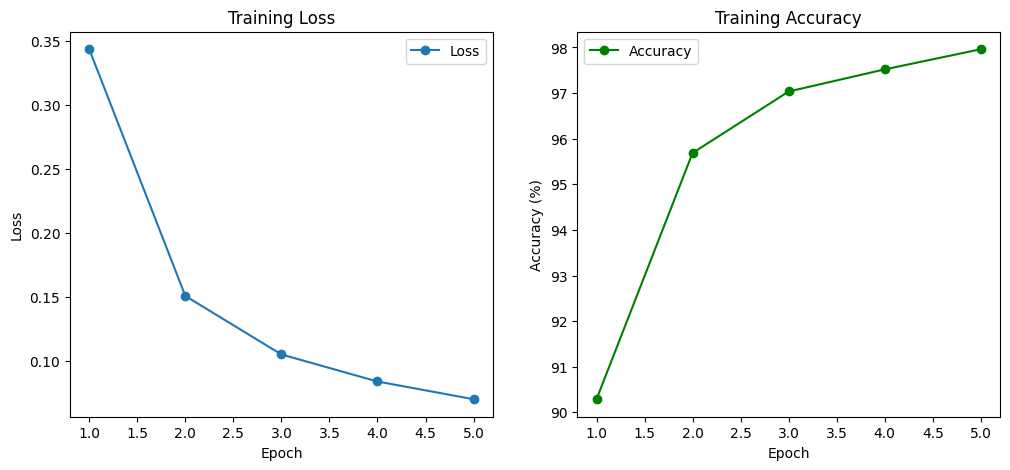

In [14]:
    # Initialize model, loss, and optimizer
    modelR = FuzzyCNNWithRegP(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelR.parameters(), lr=0.001)

    # Train the model
    train(modelR, train_loader, criterion, optimizer, epochs=5)

In [16]:
!pip install torchsummary

In [17]:
from torchsummary import summary

def model_summary(model, input_size=(1, 28, 28)):
    """
    Print a summary of the model, including layers, output shapes, and parameter counts.

    :param model: PyTorch model instance
    :param input_size: Input shape for the model (excluding batch size)
    """
    print("----- Model Summary -----")
    print(model)
    print("\n----- Layer-wise Details -----")
    summary(model, input_size=input_size)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n----- Parameter Details -----")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")

    # If RegP is present, provide its status.
    if hasattr(model, 'get_regp_loss'):
        print("\nRegP Enabled: Yes")
    else:
        print("\nRegP Enabled: No")

In [18]:
model_summary(modelMax, input_size=(1, 28, 28))

----- Model Summary -----
MaxPoolingCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPoolingLayer()
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

----- Layer-wise Details -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
   MaxPoolingLayer-2           [-1, 32, 14, 14]               0
            Linear-3                   [-1, 10]          62,730
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.24
Estimated Total Size (MB): 0.48
----------------------------------------------------------------

----- Parameter Details -----
Total Parameters: 63,050
Trainable Parameters: 63,050
Non-trainable Parameters: 0

RegP 

In [19]:
model_summary(modelFuzzy, input_size=(1, 28, 28))

----- Model Summary -----
FuzzyCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fuzzy_pool): FuzzyPoolingLayer()
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

----- Layer-wise Details -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
 FuzzyPoolingLayer-2           [-1, 32, 14, 14]               0
            Linear-3                   [-1, 10]          62,730
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.24
Estimated Total Size (MB): 0.48
----------------------------------------------------------------

----- Parameter Details -----
Total Parameters: 63,050
Trainable Parameters: 63,050
Non-trainable Parameters: 0

RegP E

In [20]:
model_summary(modelR, input_size=(1, 28, 28))

----- Model Summary -----
FuzzyCNNWithRegP(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fuzzy_pool): FuzzyPoolingLayer()
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

----- Layer-wise Details -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
 FuzzyPoolingLayer-2           [-1, 32, 14, 14]               0
            Linear-3                   [-1, 10]          62,730
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.24
Estimated Total Size (MB): 0.48
----------------------------------------------------------------

----- Parameter Details -----
Total Parameters: 63,050
Trainable Parameters: 63,050
Non-trainable Parameters: 0

In [21]:
model_summary(modelAvg, input_size=(1, 28, 28))

----- Model Summary -----
CNNWithAveragePooling(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool): AveragePoolingLayer(
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

----- Layer-wise Details -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         AvgPool2d-2           [-1, 32, 14, 14]               0
AveragePoolingLayer-3           [-1, 32, 14, 14]               0
            Linear-4                   [-1, 10]          62,730
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.24
Estimated Total Size (MB): 0.53
----------------------------------------------